In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from ellipse import LsqEllipse
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from skimage import io
import matplotlib.pyplot as plt
import math
import pickle
import statistics
from statistics import mean
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot
import pickle

# Viscosity of 0.05% glycerol (4 uL glycerol + 196 uL)

viscosity from Rheometer data

In [2]:
#expected D
kb=1.380649*10**(-23) # J*K^(-1)
T=300 # K
eta=0.71 # Pa*S
r=54*10**(-9) # m
D=kb*T/(6*math.pi*eta*r) #m^2/s
print(D) #m^2/s

5.731275770080392e-15


## 10x Objective

In [4]:
video_time_length=40 #s
imgname='10xobj_50p405nm_0p36au_40s_0p05100nmbeads_in_glycerol'
foldername='/Volumes/WENYUN WANG/20221115/'

In [5]:
# read the image stack
img = io.imread(foldername+imgname+'.tif')
frame_number=img.shape[0]
img_height=img.shape[1]
img_width=img.shape[2]
framespeed=video_time_length/frame_number

# Temporal autocorrelation
0.05% 100nm in diameter PS beads in glycerol

In [4]:
def compute_g2t_wo_kernel(px,laglist_g2t):
    intensity=[]
    for t in range(0,img.shape[0],1):
        intensity.append(img[t][px[0],px[1]])
        
    g2t=[]
    for lag in laglist_g2t:
        numerator_sum=0
        denumerator_sum_1=0
        denumerator_sum_2=0
        max_t_range=5000
        for t in range(0,max_t_range,1):
            numerator_sum=numerator_sum+int(intensity[t])*int(intensity[t+lag])
            denumerator_sum_1=denumerator_sum_1+int(intensity[t])
            denumerator_sum_2=denumerator_sum_2+int(intensity[t+lag])
        numerator=numerator_sum/max_t_range
        denumerator_1=denumerator_sum_1/max_t_range
        denumerator_2=denumerator_sum_2/max_t_range
        g2t.append((numerator/denumerator_1/denumerator_2)-1)
    return g2t

In [8]:
laglist_g2t=range(0,500,1)
averaged_g2t=[]
for y in range(12,15,1):
    for x in range(10,15,1):
        px=[y,x]
        g2t=compute_g2t_wo_kernel(px,laglist_g2t)
        averaged_g2t.append(g2t)

In [9]:
average_g2t=np.mean(averaged_g2t,axis=0)
pickle.dump(average_g2t, open(foldername+imgname+'_g2tcorrrelation_avg.p',"wb"))

In [10]:
average_g2t=pickle.load(open(foldername+imgname+'_g2tcorrrelation_avg.p', "rb"))
laglist_g2t=range(0,len(average_g2t),1)
lagtime_g2t= [element * framespeed for element in laglist_g2t]

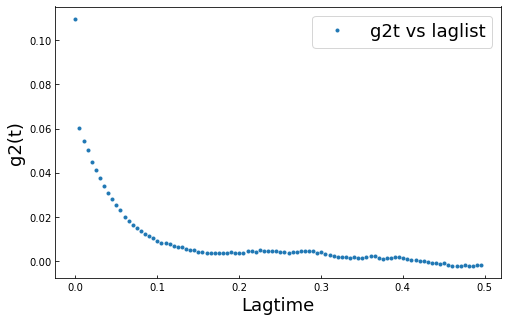

In [11]:
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t[0:100],average_g2t[0:100],'.')
plt.legend(['g2t vs laglist'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)
plt.tick_params(direction='in')

tau is: 0.05022571770724384
y = -19.91012 * x + -2.69627


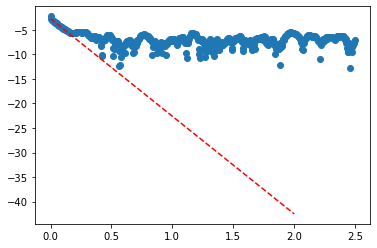

R square is 0.9994793450641839


In [12]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0 #np.mean(average_g2t[100:200])
tau, a, b=fit_exponential_decay_rsq(plateau,np.array(average_g2t),lagtime_g2t,1,20, True)

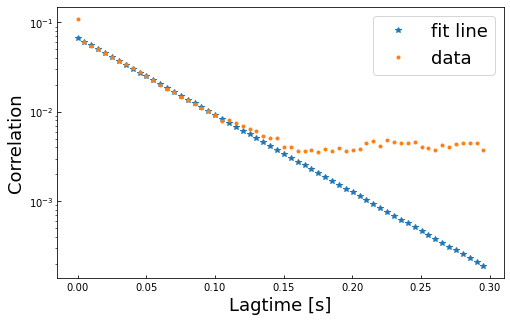

In [13]:
reconstruct(lagtime_g2t[0:60],plateau,np.array(average_g2t[0:60]),a,b)
#plt.ylim(0,0.1)
#plt.xlim(0,lagtime_g2t[20])
plt.yscale("log")

In [14]:
n=1.47
angle=np.arange(180-19.77,180+19.77,1)
lamda=405 #nm
k=2*math.pi/lamda
q=2*k*np.sin(np.radians(angle/2))*10**(9)*n

q=np.mean(q)
D=a/(-2*q**2)
print(D)

4.834075532062688e-15


# TRC

In [6]:
frame_number

7989

In [9]:
img.shape

(7989, 32, 256)

In [72]:
# for one pixel
def TRC(pixel,kernel_size, t_interest, tau_interest):
    correlation_2d=np.zeros((len(t_interest),len(tau_interest)))
    total_tlength=len(t_interest)+len(tau_interest)
    # get intensity data
    intensity=np.zeros((total_tlength, 2*kernel_size, 2*kernel_size))
    y=pixel[0]
    x=pixel[1]
    for yindex,i in enumerate(range(y-kernel_size, y+kernel_size)):
        for xindex, j in enumerate(range(x-kernel_size, x+kernel_size)):
            for t in range(total_tlength):
                intensity[t,yindex,xindex]=img[t,i,j]
    value=(2*kernel_size)**2
    intensity=np.reshape(intensity,(total_tlength, value))
    print(intensity.shape)
    # compute correlation
    for t in t_interest:
        for tau in tau_interest:
            numerator=[]
            denum1=[]
            denum2=[]
            for i in range(intensity.shape[1]):
                It=intensity[t,i]
                Ittau=intensity[t+tau,i]
                numerator.append(It*Ittau)
                denum1.append(It)
                denum2.append(Ittau)
            correlation_2d[t,tau]=np.array(numerator).mean()/(np.array(denum1).mean()*np.array(denum2).mean())-1
            correlation_2d[t,tau]=correlation_2d[t,tau]/correlation_2d[t,0]
    
    return correlation_2d

In [74]:
laglist_g2t=range(0,50,1)
t_range=range(0,500,1)
TRC_corr=TRC([15,125],10,t_range,laglist_g2t)

(550, 400)


In [75]:
TRC_corr.shape

(500, 50)

(array([ 49., 134., 153.,  92.,  27.,  27.,  10.,   4.,   2.,   2.]),
 array([0.01690606, 0.03287033, 0.0488346 , 0.06479887, 0.08076314,
        0.09672741, 0.11269168, 0.12865595, 0.14462022, 0.16058449,
        0.17654876]),
 <BarContainer object of 10 artists>)

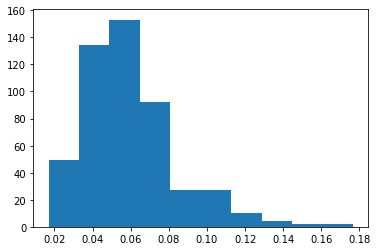

In [76]:
plt.hist(TRC_corr[:,1])

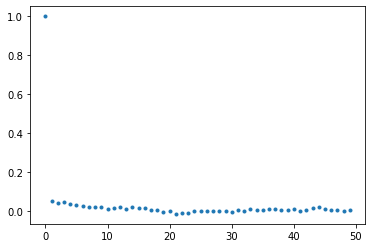

In [71]:
plt.plot(TRC_corr[10,:],'.')

# line scanning

In [158]:
def compute_g2t_wo_kernel_line(img,x,laglist_g2t):
    intensity=[]
    for t in range(0,img.shape[1],1):
        intensity.append(img[0,t,0,0,0,x,0])
    plt.plot(intensity[0:50],'-')
        
    g2t=[]
    for lag in laglist_g2t:
        numerator_sum=0
        denumerator_sum_1=0
        denumerator_sum_2=0
        max_t_range=5000
        for t in range(0,max_t_range,1):
            numerator_sum=numerator_sum+int(intensity[t])*int(intensity[t+lag])
            denumerator_sum_1=denumerator_sum_1+int(intensity[t])
            denumerator_sum_2=denumerator_sum_2+int(intensity[t+lag])
        numerator=numerator_sum/max_t_range
        denumerator_1=denumerator_sum_1/max_t_range
        denumerator_2=denumerator_sum_2/max_t_range
        g2t.append((numerator/denumerator_1/denumerator_2)-1)
    return g2t

In [159]:

imgname='10xobj_50p405nm_0p36au_40s_0p05100nmbeads_in_glycerol_line'
foldername='/Volumes/WENYUN WANG/20221115/'

In [160]:
import czifile
from skimage import io

img = czifile.imread(foldername+imgname+".czi")

In [161]:
img.shape

(1, 204887, 1, 1, 1, 256, 1)

In [162]:
img[0,3,0,0,0,9,0]

71

In [163]:
40/204887

0.00019522956556540923

In [164]:
# read the image stack
frame_number=img.shape[1]
img_width=img.shape[5]
framespeed=video_time_length/frame_number

In [165]:
img.shape

(1, 204887, 1, 1, 1, 256, 1)

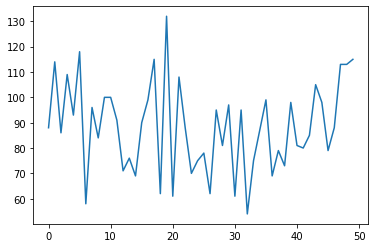

In [170]:
laglist_g2t=range(0,500,1)
averaged_g2t=[]
for x in range(134,135,1):
    g2t=compute_g2t_wo_kernel_line(img,x,laglist_g2t)
    averaged_g2t.append(g2t)

In [171]:
average_g2t=np.mean(averaged_g2t,axis=0)
pickle.dump(average_g2t, open(foldername+imgname+'_g2tcorrrelation_avg.p',"wb"))

In [172]:
average_g2t=pickle.load(open(foldername+imgname+'_g2tcorrrelation_avg.p', "rb"))
laglist_g2t=range(0,len(average_g2t),1)
lagtime_g2t= [element * framespeed for element in laglist_g2t]

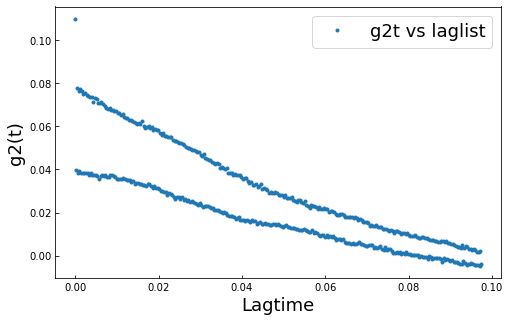

In [173]:
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t[0:2000],average_g2t[0:2000],'.')
plt.legend(['g2t vs laglist'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)
plt.tick_params(direction='in')